In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# df_summaries = pd.read_csv("data/articles_summary_cleaned.csv", parse_dates=["date"])
# df_summaries

In [3]:
# df_articles = pd.read_csv("data/all_africa_southsudan.csv")
# df_articles

In [4]:
# print(df_articles.date.unique().shape)

In [5]:
df_tabular = pd.read_csv("data/food_crises_interpol")

In [6]:
df_tabular

,Unnamed: 0,district,ipc,year_month,ndvi_mean,ndvi_anom,rain_mean,rain_anom,et_mean,et_anom,...,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct,prev_ipc,2prev_ipc,next_ipc
0,4,Bor,1.0,2009-11-01,0.472371,85.85184,2.314890,-4.467705,7.499793,-5.234680,...,11,1.197838,14008.3300,7.961984,256618.0,11393.760,90.8503,2.0,2.0,1.0
1,5,Bor,1.0,2009-12-01,0.309300,74.78490,0.930444,0.148704,2.397086,-1.174480,...,22,1.205884,14008.3300,7.961984,256618.0,11393.760,90.8503,2.0,2.0,1.0
2,6,Bor,1.0,2010-01-01,0.253501,83.79816,0.293134,-0.068916,0.167976,-0.454393,...,0,1.238529,14008.3300,7.961984,265263.0,11393.760,90.8503,2.0,2.0,2.0
3,7,Bor,1.0,2010-02-01,0.220465,85.87476,1.406630,0.521490,0.584436,-0.002676,...,0,1.262956,14008.3300,7.961984,265263.0,11393.760,90.8503,1.0,2.0,2.0
4,8,Bor,1.0,2010-03-01,0.218581,86.85130,3.486286,-0.695863,0.709874,-0.883881,...,0,1.293821,14008.3300,7.961984,265263.0,11393.760,90.8503,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9589,9978,Malakal,3.0,2019-09-01,0.732776,105.04350,21.907970,2.402068,30.342330,5.189004,...,0,80.662170,757.7855,13.068690,102228.0,7145.909,85.5000,3.0,3.0,3.0
9590,9979,Malakal,3.0,2019-10-01,0.681990,113.37050,14.913800,2.580618,22.853360,6.053181,...,0,82.872570,757.7855,13.068690,102228.0,7145.909,85.5000,3.0,3.0,4.0
9591,9980,Malakal,3.0,2019-11-01,0.556748,116.75300,0.645686,-0.091687,13.372410,8.745254,...,0,87.728720,757.7855,13.068690,102228.0,7145.909,85.5000,3.0,3.0,4.0
9592,9981,Malakal,3.0,2019-12-01,0.400063,117.55830,0.046705,-0.000951,3.089540,1.698060,...,0,93.566750,757.7855,13.068690,102228.0,7145.909,85.5000,3.0,3.0,4.0


In [7]:
df_tabular = df_tabular.set_index('year_month')
df_tabular.index = pd.to_datetime(df_tabular.index)
df_tabular['timestamp']=df_tabular.index

In [8]:
df_tabular.columns

Index(['Unnamed: 0', 'district', 'ipc', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'prev_ipc', '2prev_ipc', 'next_ipc', 'timestamp'],
      dtype='object')

In [10]:
df_model = df_tabular[['district', 'ipc', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'timestamp']]

In [11]:
train = df_model.loc[(df_model.index >= '2007-01-01') & (df_model.index < '2019-03-01')]
# val = df_model.loc[(df_model.index >= '2019-03-01') & (df_model.index < '2019-09-01')]
test = df_model.loc[df_model.index >= '2019-03-01']

In [12]:
test.timestamp

year_month
2019-03-01   2019-03-01
2019-04-01   2019-04-01
2019-05-01   2019-05-01
2019-06-01   2019-06-01
2019-07-01   2019-07-01
                ...    
2019-09-01   2019-09-01
2019-10-01   2019-10-01
2019-11-01   2019-11-01
2019-12-01   2019-12-01
2020-01-01   2020-01-01
Name: timestamp, Length: 858, dtype: datetime64[ns]

In [13]:
train.index

DatetimeIndex(['2009-11-01', '2009-12-01', '2010-01-01', '2010-02-01',
               '2010-03-01', '2010-04-01', '2010-05-01', '2010-06-01',
               '2010-07-01', '2010-08-01',
               ...
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01'],
              dtype='datetime64[ns]', name='year_month', length=8736, freq=None)

In [14]:
test.index

DatetimeIndex(['2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01',
               ...
               '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
               '2019-12-01', '2020-01-01'],
              dtype='datetime64[ns]', name='year_month', length=858, freq=None)

# DeepAR

In [ ]:
# pip install gluonts

In [15]:
from gluonts.dataset.pandas import PandasDataset

train_ds = PandasDataset.from_long_dataframe(train, target='ipc', item_id='district', 
                                       timestamp='timestamp', freq='M')

C:\Users\Goshko\anaconda3\envs\dc3\lib\site-packages\gluonts\json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [16]:
# pip install torch

In [17]:
# pip install pytorch_lightning

In [18]:
train_ds

PandasDataset<size=78, freq=M, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [19]:
from gluonts.torch.model.deepar import DeepAREstimator

estimator = DeepAREstimator(freq='M', prediction_length=6, num_layers=3, lr=0.002, context_length=12,
                            trainer_kwargs={'max_epochs':4})

predictor = estimator.train(train_ds, num_workers=4)

C:\Users\Goshko\anaconda3\envs\dc3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Goshko\anaconda3\envs\dc3\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
C:\Users\Goshko\anacond

Epoch 0: : 50it [00:02, 20.53it/s, v_num=23, train_loss=1.130]

Epoch 0, global step 50: 'train_loss' reached 1.13329 (best 1.13329), saving model to 'C:\\Users\\Goshko\\Desktop\\DC3\\JBG060-DC3-23-24-public-main\\lightning_logs\\version_23\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: : 50it [00:02, 20.36it/s, v_num=23, train_loss=0.633]

Epoch 1, global step 100: 'train_loss' reached 0.63255 (best 0.63255), saving model to 'C:\\Users\\Goshko\\Desktop\\DC3\\JBG060-DC3-23-24-public-main\\lightning_logs\\version_23\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: : 50it [00:02, 20.98it/s, v_num=23, train_loss=0.548]

Epoch 2, global step 150: 'train_loss' reached 0.54775 (best 0.54775), saving model to 'C:\\Users\\Goshko\\Desktop\\DC3\\JBG060-DC3-23-24-public-main\\lightning_logs\\version_23\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: : 50it [00:02, 20.52it/s, v_num=23, train_loss=0.504]

Epoch 3, global step 200: 'train_loss' reached 0.50363 (best 0.50363), saving model to 'C:\\Users\\Goshko\\Desktop\\DC3\\JBG060-DC3-23-24-public-main\\lightning_logs\\version_23\\checkpoints\\epoch=3-step=200.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: : 50it [00:02, 20.25it/s, v_num=23, train_loss=0.504]


In [20]:
pred = list(predictor.predict(train_ds))
all_preds = list()

for district in pred:
    district_name = district.item_id
    p = district.samples.mean(axis=0)
    # make 80% confidence interval
    p10 = np.percentile(district.samples, 10, axis=0)
    p90 = np.percentile(district.samples, 90, axis=0)
    dates = pd.date_range(start=district.start_date.to_timestamp(), periods=len(p), freq='M')
    dates2 = []
    for month in dates:
        day_num = month.strftime("%d")
        month_reset = month - timedelta(days=int(day_num) - 1)
        dates2.append(month_reset)
    district_pred = pd.DataFrame({'timestamp': dates2, 'district': district_name, 'pred': p, 'p10': p10, 'p90': p90})
    all_preds += [district_pred]

all_preds = pd.concat(all_preds, ignore_index=True)

# all_preds['date'] = all_preds.timestamp
# all_preds = all_preds.set_index('date')
# all_preds.index = pd.to_datetime(all_preds.index)
# all_preds.timestamp=all_preds.index

all_preds = all_preds.merge(test, on=['timestamp', 'district'], how='left')

In [21]:
all_preds

,timestamp,district,pred,p10,p90,ipc,ndvi_mean,ndvi_anom,rain_mean,rain_anom,et_mean,et_anom,count_violence,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct
0,2019-03-01,Abiemnhom,3.274857,2.747409,3.963900,3.0,0.276236,105.41210,0.905209,-0.197965,0.002087,-0.101534,3,5,56.86615,2408.233,1.742261,233166.0,11004.64,91.48276
1,2019-04-01,Abiemnhom,3.450106,2.899800,4.075443,3.0,0.301412,105.43540,4.200479,1.628610,0.094115,-0.578187,1,2,60.13975,2408.233,1.742261,233166.0,11004.64,91.48276
2,2019-05-01,Abiemnhom,3.521290,2.959127,4.134379,3.0,0.369932,93.22445,16.593870,3.277647,2.348514,-1.312987,1,2,63.56867,2408.233,1.742261,233166.0,11004.64,91.48276
3,2019-06-01,Abiemnhom,3.430143,2.698156,4.166745,3.0,0.653733,107.51550,29.909640,7.759687,19.956610,6.503822,2,1,67.31876,2408.233,1.742261,233166.0,11004.64,91.48276
4,2019-07-01,Abiemnhom,3.467110,2.863068,4.164576,3.0,0.746115,103.04760,27.005520,-0.795216,34.856580,8.504764,0,0,69.03657,2408.233,1.742261,233166.0,11004.64,91.48276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2019-04-01,Yirol West,3.721852,3.108435,4.281260,3.0,0.333928,97.20854,8.000770,-5.516576,5.504908,0.301214,1,1,67.30182,4879.717,0.462767,154856.0,25073.43,87.71930
464,2019-05-01,Yirol West,3.730595,2.822160,4.537534,3.0,0.473855,88.21682,21.244750,-0.825497,14.344340,0.069222,1,0,73.10890,4879.717,0.462767,154856.0,25073.43,87.71930
465,2019-06-01,Yirol West,3.752142,2.947415,4.472791,4.0,0.663466,96.93623,32.142000,8.220712,25.769410,2.144067,0,0,79.46993,4879.717,0.462767,154856.0,25073.43,87.71930
466,2019-07-01,Yirol West,3.629531,2.794902,4.594999,3.0,0.755503,103.20960,21.690270,-1.063479,34.328130,4.633834,0,0,81.82270,4879.717,0.462767,154856.0,25073.43,87.71930


In [22]:
def reg_evaluation(y_test, y_pred, district: str):    
    print(f'Results for {district}:')
    print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_pred),2))
    print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
    print('Weighted mean absolute percentage error:', 
          round(np.abs(y_test - y_pred).sum() / np.abs(y_test).sum(),2))
    print('\n')

# do clf eval after the rounding!!!

In [23]:
reg_evaluation(all_preds['ipc'], all_preds['pred'], 'all districts')

Results for all districts:
Mean Absolute Error: 0.43
Root Mean Squared Error: 0.47
Weighted mean absolute percentage error: 0.14




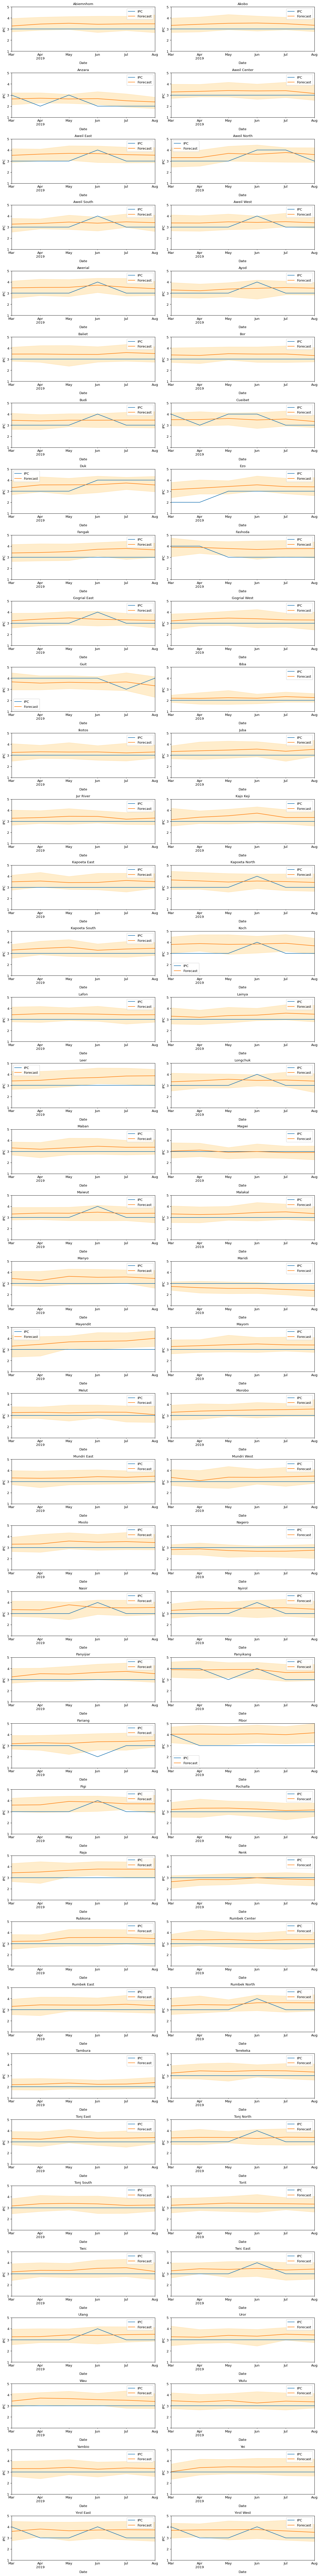

In [24]:
fig, ax = plt.subplots(39,2, figsize=(1280/96, 1280/12), dpi=96)
ax = ax.flatten()

for ax_, ward in enumerate(all_preds['district'].unique()):
    p_ = all_preds.loc[all_preds['district'] == ward]
    p_.plot(x='timestamp', y='ipc', ax=ax[ax_], label='IPC')
    p_.plot(x='timestamp', y='pred', ax=ax[ax_], label='Forecast')
    ax[ax_].fill_between(p_['timestamp'].values, p_['p10'], p_['p90'], alpha=0.2, color='orange')
    ax[ax_].set_title(ward, fontsize=10)
    ax[ax_].legend(fontsize=10)
    ax[ax_].set_xlabel('Date', fontsize=10)
    ax[ax_].set_ylabel('IPC', fontsize=10)
    ax[ax_].tick_params(axis='both', which='major', labelsize=10)
    ax[ax_].tick_params(axis='both', which='minor', labelsize=10)
    ax[ax_].set_ylim(1,5)
    
fig.tight_layout()